In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs
import configs
from utils import get_firing_field

device = 'cpu'

/Users/chingfang/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")
/Users/chingfang/Code/sr-project/datasets/sf_inputs_discrete.py:19: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [54]:
def run_and_plot(exp_dir):
    """
    Plots example M matrices for unbiased and forward-biased 1D walks.
    """
    
    num_states = 20

    # Test datasets
    dsets = [
        inputs.Sim1DWalk(num_steps=2000, num_states=num_states, left_right_stay_prob=[1,1,1]),
        inputs.Sim1DWalk(num_steps=2000, num_states=num_states, left_right_stay_prob=[4,1,1])
        ]

    # Load model
    with open(exp_dir + 'net_configs.p', 'rb') as f:
        net_configs = pickle.load(f)
    net_configs['num_states'] = num_states
    net = STDP_SR(**net_configs)
    state_dict = torch.load(exp_dir + 'model.pt')
    net.load_state_dict(state_dict)
    net.set_num_states(num_states)
    print(net_configs)
    
    # Set up figs
    fig, axs = plt.subplots(1, len(dsets))
    
    # Run datasets
    for idx, dset in enumerate(dsets):
        dg_inputs = torch.from_numpy(dset.dg_inputs.T).float().to(device).unsqueeze(1)
        with torch.no_grad():
            _, outputs = net(dg_inputs, reset=True)
        rnn_M = net.get_M()
        try:
            rnn_M = rnn_M.numpy()
        except:
            pass
        axs[idx].imshow(rnn_M)
        
        # Plot example activity
        plt.figure(figsize=(20,4))
        plt.imshow(outputs[-300:].numpy().T, aspect=2)
        plt.colorbar()
    plt.show()
        
    # Plot true matrices
    fig, axs = plt.subplots(1, len(dsets))
    for idx, dset in enumerate(dsets):
        est_T = dset.est_T
        est_M = np.linalg.pinv(
            np.eye(est_T.shape[0]) - net.gamma*est_T
            )
        axs[idx].imshow(est_M)
    plt.show()

    return np.mean(np.abs(rnn_M - est_M))

# No nonlinearity, steady state activity, $\gamma=0.6$

{'gamma': 0.7, 'num_states': 20}


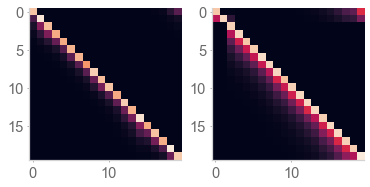

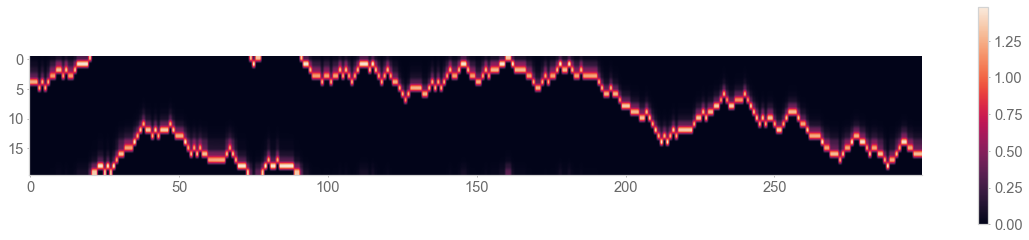

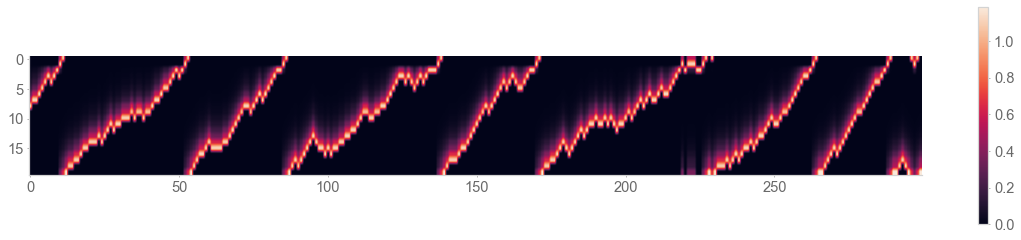

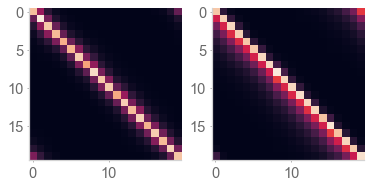

0.05105667769406591

In [55]:
exp_dir = f"{configs.engram_dir}02_gamma_v_ss/None/0.7/1/"
run_and_plot(exp_dir)

# No nonlinearity, 15 recurrent iterations, $\gamma=0.8$

{'gamma': 0.7, 'ca3_kwargs': {'A_pos_sign': 1, 'A_neg_sign': -1, 'output_params': {'num_iterations': 20, 'input_clamp': 20, 'nonlinearity': None}}, 'num_states': 20}


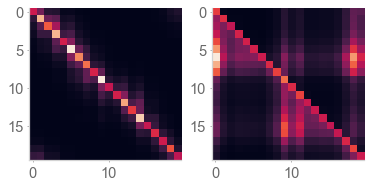

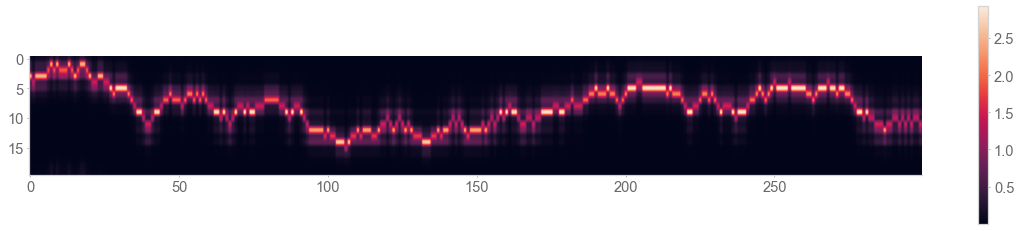

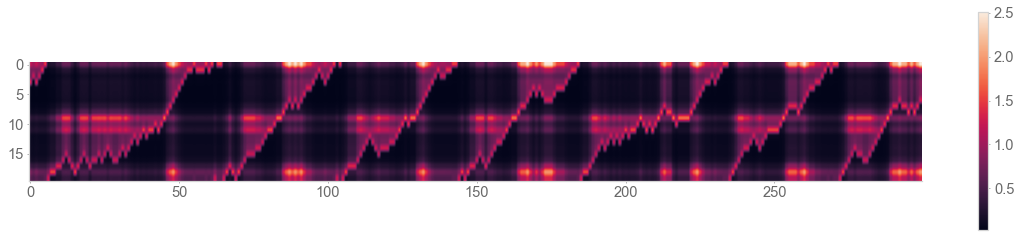

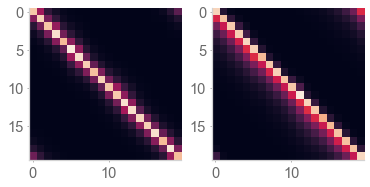

0.28499292304899926

In [56]:
exp_dir = f"{configs.engram_dir}02_gamma_v_rsteps/0.7/20/None/6/"
run_and_plot(exp_dir)

# ReLU nonlinearity, 15 recurrent iterations, $\gamma=0.8$

{'gamma': 0.8, 'ca3_kwargs': {'A_pos_sign': 1, 'A_neg_sign': -1, 'output_params': {'num_iterations': 20, 'input_clamp': 20, 'nonlinearity': 'relu'}}, 'num_states': 20}


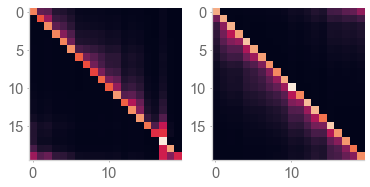

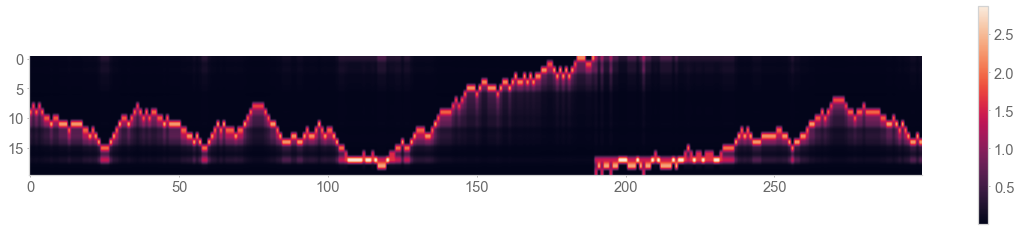

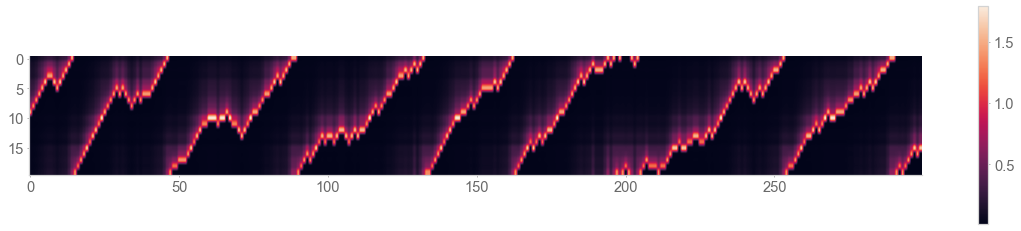

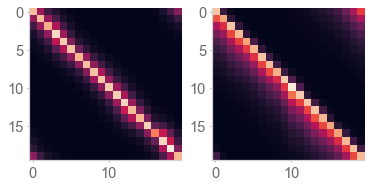

0.07717431620551199

In [61]:
exp_dir = f"{configs.engram_dir}02_gamma_v_rsteps/0.8/20/relu/4/"
run_and_plot(exp_dir)